# Feed-forward Neural Network model for proportional muscular fatigue estimation

## Importing and installing libraries and defining global variables

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import joblib
import time

In [2]:
seed_value = 42
np.random.seed(seed_value)
torch.manual_seed(seed_value)
if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed_value)

In [8]:
EXP_TYPE = 'SINGLE' # Options: 'SINGLE', 'MULTIPLE'
FEATURE = 'MAV' # Options: 'RAW', 'MAV', 'RMS', 'MNF'
USER = 'H032B0101' # Options: 'H001B0101', 'H002B0101', 'H003B0101', 'H004B0101', 'H022B0101', 'H023B0101', 'H024B0101', 'H031B0101', 'H032B0101'
LEVEL_TYPE = 'INT' # Options: 'FLOAT', 'INT'
NUM_HIDDEN_LAYERS = 3 # Options: 1, 3
OPT_MODEL = 'GRID' # Options: 'GRID', 'RANDOM', 'BAYES', 'ASHA'

### Install if using Grid-search, Random-search or Bayes-search

In [ ]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 8.2 MB/s eta 0:00:00


In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 4.5 MB/s eta 0:00:00


### Install if using ASHAScheduler

In [ ]:
!pip install ray
# !pip install -U tensorboardx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.3/65.3 MB 9.8 MB/s eta 0:00:00


## Data Loading

In [4]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
if FEATURE == 'RAW':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4.csv"

elif FEATURE == 'MAV':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_mav.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_mav.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_mav.csv"

elif FEATURE == 'RMS':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_rms.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_rms.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_rms.csv"

elif FEATURE == 'MNF':
  run2 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_2_mnf.csv"
  run3 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_3_mnf.csv"
  run4 = f"/content/drive/MyDrive/HDEMG/{USER}/emg_experiment_4_mnf.csv"

In [9]:
if EXP_TYPE == 'SINGLE':
  hdemg_data = pd.read_csv(run2) # Load data containing HD-EMG signals

  if (USER == 'H001B0101' or USER == 'H002B0101' or USER == 'H003B0101') and FEATURE == 'MAV':
    hdemg_data = hdemg_data.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak

  # Generate the fatigue levels with linear assumption
  if LEVEL_TYPE == 'FLOAT':
    fatigue_level_synthetic = np.linspace(0, 100, num=hdemg_data.shape[0])
  elif LEVEL_TYPE == 'INT':
    fatigue_level_synthetic = np.linspace(0, 100, num=hdemg_data.shape[0]).astype(int)

# ------------------------------------------------------------------------------

elif EXP_TYPE == 'MULTIPLE':
  # Load data containing HD-EMG signals
  hdemg_data_2 = pd.read_csv(run2)
  hdemg_data_3 = pd.read_csv(run3)
  hdemg_data_4 = pd.read_csv(run4)

  if (USER == 'H001B0101' or USER == 'H002B0101' or USER == 'H003B0101') and FEATURE == 'MAV':
    # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_2 = hdemg_data_2.iloc[:-1000]
    hdemg_data_3 = hdemg_data_3.iloc[:-1000]
    hdemg_data_4 = hdemg_data_4.iloc[:-1000]

  # Generate the fatigue levels with linear assumption
  if LEVEL_TYPE == 'FLOAT':
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0])
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0])
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0])
  elif LEVEL_TYPE == 'INT':
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0]).astype(int)
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0]).astype(int)
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0]).astype(int)

  # Add columns names, as the original dataframe doesn't have any
  new_columns = [f"Channel {i}" for i in range(1, 65)]
  hdemg_data_2.columns = new_columns
  hdemg_data_3.columns = new_columns
  hdemg_data_4.columns = new_columns

  # Concatenate experiment runs 2 and 3, as it's the train data
  hdemg_data = pd.concat([hdemg_data_2, hdemg_data_3], axis=0)
  fatigue_level_2_df = pd.DataFrame(fatigue_level_2,columns=["Fatigue level"])
  fatigue_level_3_df = pd.DataFrame(fatigue_level_3,columns=["Fatigue level"])
  fatigue_level_synthetic = pd.concat([fatigue_level_2_df, fatigue_level_3_df], axis=0)

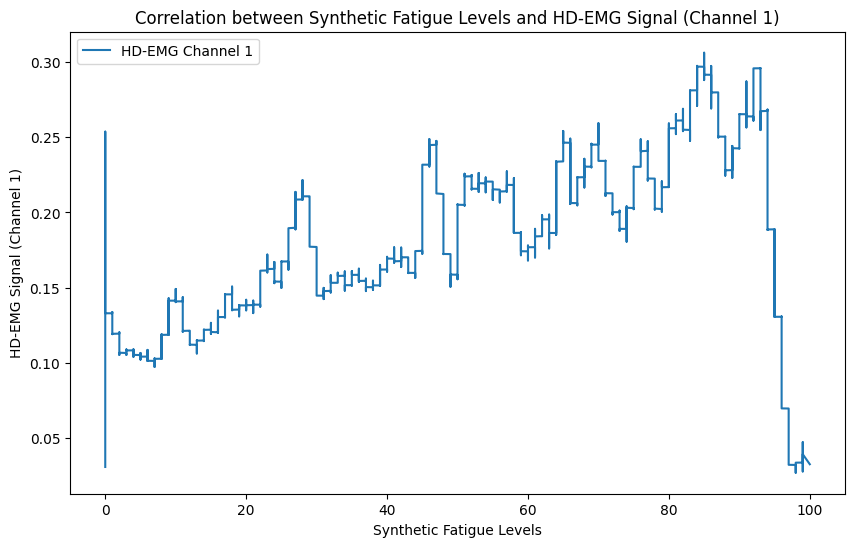

In [10]:
if EXP_TYPE == 'SINGLE':
  # Define the number of samples and channels
  samples = hdemg_data.shape[0]
  channels = hdemg_data.shape[1]

  # Create synthetic labels for fatigue levels
  yn = np.linspace(0, 100, num=samples)

  # Show HD-EMG signal and fatigue level correlation for a single channal
  plt.figure(figsize=(10, 6))
  plt.plot(fatigue_level_synthetic, hdemg_data.iloc[:, 0], label='HD-EMG Channel 1')
  plt.xlabel('Synthetic Fatigue Levels')
  plt.ylabel('HD-EMG Signal (Channel 1)')
  plt.title('Correlation between Synthetic Fatigue Levels and HD-EMG Signal (Channel 1)')
  plt.legend()
  plt.show()

## Auxiliary functions

In [11]:
def batch_generator(inputs, targets, batch_size):
  num_samples = len(inputs)
  indices = np.arange(num_samples)  # Generate an array of indices corresponding to each sample

  for i in range(0, num_samples, batch_size):
    batch_indices = indices[i:i+batch_size] # Select the indices for the current batch

    # Use the selected indices to extract the inputs and targets for the batch
    batch_inputs = inputs[batch_indices]
    batch_targets = targets[batch_indices]

    yield batch_inputs, batch_targets # Using yield instead of return to create the batches gradually instead of storing them all in memory at once

In [12]:
class EarlyStopping:
  def __init__(self, patience=5, delta=0, verbose=False, path='checkpoint.pt', trace_func=print):
    """
    Initialize the EarlyStopping object.

    Args:
        patience (int): Number of epochs to wait before early stopping if no improvement is seen.
        delta (float): Minimum change in monitored quantity to qualify as an improvement.
        verbose (bool): If True, prints a message for each improvement.
        path (str): Path for saving the model checkpoint.
    """
    self.patience = patience
    self.delta = delta
    self.verbose = verbose
    self.path = path
    # self.trace_func = trace_func
    self.counter = 0
    self.best_score = None
    self.early_stop = False
    self.val_loss_min = np.Inf

  def __call__(self, val_loss, model):
    """
    Call method to track validation loss and decide whether to early stop.

    Args:
        val_loss (float): Current validation loss.
        model: PyTorch model being trained.
    """
    score = -val_loss # Using negative loss to prioritize higher scores for better performance

    if self.best_score is None:  # If no best score is set yet, initialize it with the current score and save the model checkpoint
        self.best_score = score
        self.save_checkpoint(val_loss, model)
    elif score < self.best_score + self.delta: # If the score does not improve by at least the delta value, increment the counter
        self.counter += 1
        print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
        if self.counter >= self.patience: # If the counter exceeds the patience threshold, update the flag
            self.early_stop = True
    else: # If the score improves, update the best_score, save the model checkpoint, and reset the counter
        self.best_score = score
        self.save_checkpoint(val_loss, model)
        self.counter = 0

  def save_checkpoint(self, val_loss, model):
    """
    Save model checkpoint if validation loss has decreased.

    Args:
        val_loss (float): Current validation loss.
        model: PyTorch model being trained.
    """
    if self.verbose:
        print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
    torch.save(model.state_dict(), self.path)
    self.val_loss_min = val_loss

## Model definition

In [13]:
if NUM_HIDDEN_LAYERS == 1:
  class FFNN(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
          super(FFNN, self).__init__()
          self.hidden_layer = nn.Linear(input_size, hidden_size)
          self.output_layer = nn.Linear(hidden_size, output_size)
          self.activation = nn.ReLU()

      def forward(self, x):
          x = self.hidden_layer(x)
          x = self.activation(x)
          x = self.output_layer(x)
          return x

elif NUM_HIDDEN_LAYERS == 3:
  class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size,dropout_prob=0.25):
        super(FFNN, self).__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
        self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden_layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.output_layer = nn.Linear(hidden_size3, output_size)
        self.activation = nn.ReLU()
        # self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x):
        x = self.activation(self.hidden_layer1(x))
        # x = self.dropout(x)
        x = self.activation(self.hidden_layer2(x))
        # x = self.dropout(x)
        x = self.activation(self.hidden_layer3(x))
        # x = self.dropout(x)
        x = self.output_layer(x)
        return x

## Model hyperparameter optimization

### Grid-search, Random-search and Bayes-search

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from skorch import NeuralNetRegressor
from skopt import BayesSearchCV
from skopt.space import Real, Integer

if OPT_MODEL == 'GRID' or OPT_MODEL == 'RANDOM':
  param_grid = {
      'module__hidden_size': [10, 32, 64, 100],
      'lr': [0.001, 0.005, 0.01],
      'batch_size': [256, 512, 1024, 2048]
  }

elif OPT_MODEL == 'BAYES':
  param_space = {
      'module__hidden_size': Integer(10, 100),
      # 'lr': Real(1e-5, 1e-1, prior='log-uniform'),
      # 'max_epochs': Integer(50, 200),
      # 'batch_size': Integer(64, 2048)
  }

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Convert data to PyTorch tensors
inputs = torch.tensor(hdemg_data.values, dtype=torch.float32)
targets = torch.tensor(fatigue_level_synthetic, dtype=torch.float32)

# Split data into training and validation sets (80-20 split)
X_train, X_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.2, random_state=seed_value)

X_train = X_train.to(device)
X_val = X_val.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)

# Create the FFNN model with the initial parameters
model = NeuralNetRegressor(
    module=FFNN,
    module__input_size=64,
    module__output_size=1,
    optimizer=torch.optim.SGD,
    criterion=torch.nn.MSELoss,
    max_epochs=1000,
    lr=0.005,
    batch_size=2048,
    device=device
)

if OPT_MODEL == 'GRID':
  grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=0)
  result = grid_search.fit(X_train.squeeze(), y_train.unsqueeze(1)) # Train the model with grid search

if OPT_MODEL == 'RANDOM':
  random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=10, cv=3, random_state=seed_value)
  result = random_search.fit(X_train.squeeze(), y_train.unsqueeze(1))

if OPT_MODEL == 'BAYES':
  bayes_search = BayesSearchCV(
      estimator=model,
      search_spaces=param_space,
      n_iter=20,  # Number of iterations of Bayesian search
      cv=3,  # Number of cross-validation folds
      verbose=1
  )

  result = bayes_search.fit(X_train.squeeze(), y_train.unsqueeze(1))

# Summarize results
print("Best: %f using %s" % (result.best_score_, result.best_params_))
means = result.cv_results_['mean_test_score']
stds = result.cv_results_['std_test_score']
params = result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1      883.7325      676.5755  5.4867
      2      629.5708      599.8029  1.6223
      3      602.2519      585.1950  1.9858
      4      587.4044      570.1109  1.9222
      5      571.1077      553.7410  1.8344
      6      552.9520      536.3265  2.1332
      7      533.2291      518.7696  2.5718
      8      513.2253      502.0380  2.3148
      9      495.4035      487.4365  2.1932
     10      484.4964      472.3666  1.8174
     11      491.9736      454.3530  2.1576
     12      496.5966      449.3158  2.1949
     13      489.7783      445.5960  2.2579
     14      483.2683      442.5375  1.9825
     15      477.4295      439.9527  1.7357
     16      472.1742      437.7080  1.9009
     17      467.4233      435.7075  1.5898
     18      463.1077      433.8807  2.4857
     19      459.1698      432.1781  2.2205
     20      455.5598      430.5645  1.8838
     21      452.2359      429.0

KeyboardInterrupt: 

### Ray Tune

In [ ]:
import torch
import torch.nn as nn
import ray
import torch.optim as optim
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader

# Shutdown Ray if already running and then initialize in order to restart after each execution
ray.shutdown()
ray.init()

def set_reproducibillity(seed_value=None):
  if seed_value is None:
        seed_value = 42
  np.random.seed(seed_value)
  torch.manual_seed(seed_value)
  if torch.cuda.is_available():
          torch.cuda.manual_seed_all(seed_value)

# ------------------------------------------------------------------------------

# Define a custom Dataset
class CustomDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sample = self.inputs[idx]
        target_sample = self.targets[idx]
        return input_sample, target_sample

# Define the FFNN class
if NUM_HIDDEN_LAYERS == 1:
  class FFNN(nn.Module):
      def __init__(self, input_size, hidden_size, output_size):
          super(FFNN, self).__init__()
          self.hidden_layer = nn.Linear(input_size, hidden_size)
          self.output_layer = nn.Linear(hidden_size, output_size)
          self.activation = nn.ReLU()

      def forward(self, x):
          x = self.hidden_layer(x)
          x = self.activation(x)
          x = self.output_layer(x)
          return x

elif NUM_HIDDEN_LAYERS == 3:
  class FFNN(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, hidden_size3, output_size):
        super(FFNN, self).__init__()
        self.hidden_layer1 = nn.Linear(input_size, hidden_size1)
        self.hidden_layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.hidden_layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.output_layer = nn.Linear(hidden_size3, output_size)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.hidden_layer1(x))
        x = self.activation(self.hidden_layer2(x))
        x = self.activation(self.hidden_layer3(x))
        x = self.output_layer(x)
        return x

# ------------------------------------------------------------------------------

def train(config, data):
  """
  Train function for tuning hyperparameters.

  Args:
      config (dict): Configuration dictionary containing hyperparameters.
      data (tuple): Tuple containing training and validation datasets.

  Returns:
      dict: Dictionary containing the validation loss.
  """

  if config["reproducibility_active"]:
      set_reproducibillity()

  train_dataset, val_dataset = data[0], data[1]
  # Define the model and other training components
  input_size = 64
  output_size = 1
  device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

  if NUM_HIDDEN_LAYERS == 1:
    model = FFNN(input_size, config["hidden_size"], output_size)

  elif NUM_HIDDEN_LAYERS == 3:
    model = FFNN(input_size, config["hidden_size1"], config["hidden_size2"], config["hidden_size3"], output_size)

  model = model.to(device)

  criterion = nn.MSELoss()
  optimizer = optim.Adam(model.parameters(), lr=config["lr"])
  scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

  train_loss_history = []

  X_train, y_train = train_dataset.inputs, train_dataset.targets
  X_val, y_val = val_dataset.inputs, val_dataset.targets

  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_val = X_val.to(device)
  y_val = y_val.to(device)

  # Itera sobre el DataLoader
  for batch_inputs, batch_targets in batch_generator(X_train, y_train, config["batch_size"]):
      batch_inputs = batch_inputs.to(device)
      batch_targets = batch_targets.to(device)

      optimizer.zero_grad()
      train_outputs = model(batch_inputs)
      loss = criterion(train_outputs.squeeze(), batch_targets)
      train_loss_history.append(loss.item())
      loss.backward()
      optimizer.step()
      scheduler.step()

  # Validation loss
  model.eval()
  with torch.no_grad():
      val_outputs = model(X_val)
      val_loss = criterion(val_outputs.squeeze(), y_val)

  return {"val_loss": val_loss.item()}

# ------------------------------------------------------------------------------

# Load data containing HD-EMG signals
hdemg_data_2 = pd.read_csv(run2)
hdemg_data_3 = pd.read_csv(run3)
hdemg_data_4 = pd.read_csv(run4)

if USER == 'H001B0101' or USER == 'H002B0101' or USER == 'H003B0101':
    # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_2 = hdemg_data_2.iloc[:-1000]
    hdemg_data_3 = hdemg_data_3.iloc[:-1000]
    hdemg_data_4 = hdemg_data_4.iloc[:-1000]

# Generate the fatigue levels with linear assumption
if LEVEL_TYPE == 'FLOAT':
  fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0])
  fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0])
  fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0])
elif LEVEL_TYPE == 'INT':
  fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0]).astype(int)
  fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0]).astype(int)
  fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0]).astype(int)

# Add columns names, as the original dataframe doesn't have any
new_columns = [f"Channel {i}" for i in range(1, 65)]
hdemg_data_2.columns = new_columns
hdemg_data_3.columns = new_columns
hdemg_data_4.columns = new_columns

# Concatenate all experiment runs
hdemg_data_combined = pd.concat([hdemg_data_2, hdemg_data_3, hdemg_data_4], axis=0)
fatigue_level_combined = np.concatenate([fatigue_level_2, fatigue_level_3, fatigue_level_4])

inputs = torch.tensor(hdemg_data_combined.values, dtype=torch.float32)
targets = torch.tensor(fatigue_level_combined, dtype=torch.float32)

# Split data into training and validation sets (80-20 split)
train_inputs, val_inputs, train_targets, val_targets = train_test_split(inputs, targets, test_size=0.2, random_state=seed_value)

# Create an instance of the custom Dataset
train_dataset = CustomDataset(train_inputs, train_targets)
val_dataset = CustomDataset(val_inputs, val_targets)

# ------------------------------------------------------------------------------

# Define the hyperparameter search space
if NUM_HIDDEN_LAYERS == 1:
  search_space = {
      "reproducibility_active": True,
      "hidden_size": tune.choice([10, 32, 64, 100]),
      "lr": tune.loguniform(0.0001, 0.01),
      "batch_size": tune.choice([512, 768, 1024, 2048])
      #"max_epochs": tune.choice([100, 250, 500, 600, 750, 950, 1000])
  }
elif NUM_HIDDEN_LAYERS == 3:
  search_space = {
    "reproducibility_active": True,
    "hidden_size1": tune.choice([10, 32, 64, 100]),
    "hidden_size2": tune.choice([10, 32, 64, 100]),
    "hidden_size3": tune.choice([10, 32, 64, 100]),
    "lr": tune.loguniform(0.0001, 0.01),
    "batch_size": tune.choice([512, 768, 1024, 2048])
    #"max_epochs": tune.choice([100, 250, 500, 600, 750, 950, 1000])
  }

if search_space["reproducibility_active"]:
  set_reproducibillity()

# Configure hyperparameter tuning
scheduler = ASHAScheduler(
    max_t=100,  # Maximum number of iterations
    grace_period=10,
    reduction_factor=2,
    metric="val_loss",  # Specify the metric to optimize
    mode="min"  #  Specify the mode (minimization or maximization)
)

reporter = CLIReporter(metric_columns=["val_loss"])

# Run hyperparameter tuning
analysis = tune.run(
    tune.with_parameters(train, data=(train_dataset, val_dataset)),
    config=search_space,
    num_samples=30,  # Number of hyperparameter configurations to try
    scheduler=scheduler,
    progress_reporter=reporter
)

# Get the best hyperparameters
best_config = analysis.get_best_config(metric="val_loss", mode="min")
print("Best config:", best_config)

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
2024-04-17 09:56:47,967	INFO worker.py:1752 -- Started a local Ray instance.
2024-04-17 09:56:49,224	INFO tune.py:622 -- [output] This will use the new output engine with verbosity 2. To disable the new output and use the legacy output engine, set the environment variable RAY_AIR_NEW_OUTPUT=0. For more information, please see https://github.com/ray-project/ray/issues/36949
2024-04-17 09:56:49,256	WARNING callback.py:137 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`
2024-04-17 09:56:49,263	WARNING tune.py:912 -- AIR_VERBOSITY is set, ignoring passed-in ProgressReporter for now.


/content/drive/MyDrive/HDEMG LR/H001B0101/emg_experiment_2_rms.csv
+--------------------------------------------------------------+
| Configuration for experiment     train_2024-04-17_09-56-49   |
+--------------------------------------------------------------+
| Search algorithm                 BasicVariantGenerator       |
| Scheduler                        AsyncHyperBandScheduler     |
| Number of trials                 50                          |
+--------------------------------------------------------------+

View detailed results here: /root/ray_results/train_2024-04-17_09-56-49

Trial status: 50 PENDING
Current time: 2024-04-17 09:56:49. Total running time: 0s
Logical resource usage: 0/2 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:T4)
+--------------------------------------------------------------------------------------------------------------+
| Trial name          status       hidden_size1     hidden_size2     hidden_size3            lr     batch_size |
+---------------------

2024-04-17 10:00:55,826	WARNING experiment_state.py:205 -- Experiment state snapshotting has been triggered multiple times in the last 5.0 seconds. A snapshot is forced if `CheckpointConfig(num_to_keep)` is set, and a trial has checkpointed >= `num_to_keep` times since the last snapshot.
You may want to consider increasing the `CheckpointConfig(num_to_keep)` or decreasing the frequency of saving checkpoints.
You can suppress this error by setting the environment variable TUNE_WARN_EXCESSIVE_EXPERIMENT_CHECKPOINT_SYNC_THRESHOLD_S to a smaller value than the current threshold (5.0).
2024-04-17 10:00:55,850	INFO tune.py:1016 -- Wrote the latest version of all result files and experiment state to '/root/ray_results/train_2024-04-17_09-56-49' in 0.0370s.



Trial train_cefa9_00049 finished iteration 1 at 2024-04-17 10:00:55. Total running time: 4min 6s
+--------------------------------------------+
| Trial train_cefa9_00049 result             |
+--------------------------------------------+
| checkpoint_dir_name                        |
| time_this_iter_s                    2.0632 |
| time_total_s                        2.0632 |
| training_iteration                       1 |
| val_loss                           3787.66 |
+--------------------------------------------+

Trial train_cefa9_00049 completed after 1 iterations at 2024-04-17 10:00:55. Total running time: 4min 6s

Trial train_cefa9_00048 finished iteration 1 at 2024-04-17 10:00:55. Total running time: 4min 6s
+--------------------------------------------+
| Trial train_cefa9_00048 result             |
+--------------------------------------------+
| checkpoint_dir_name                        |
| time_this_iter_s                   2.07988 |
| time_total_s                       2.0

## Model training and evaluation

In [14]:
# Define early stopping object
early_stopping = EarlyStopping(patience=5, verbose=False)

# Define model parameters
input_size = 64

if NUM_HIDDEN_LAYERS == 1:
  hidden_size = 100
  lr = 0.0077
elif NUM_HIDDEN_LAYERS == 3:
  hidden_size1 = 100
  hidden_size2 = 100
  hidden_size3 = 64
  lr = 0.005

output_size = 1

num_epochs = 1000
eval_steps = 50
batch_size = 768

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create an instance of the network
if NUM_HIDDEN_LAYERS == 1:
  model = FFNN(input_size, hidden_size, output_size)
elif NUM_HIDDEN_LAYERS == 3:
  model = FFNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_epochs)

# Convert data to PyTorch tensors
inputs = torch.tensor(hdemg_data.values, dtype=torch.float32)
if EXP_TYPE == 'SINGLE':
  targets = torch.tensor(fatigue_level_synthetic, dtype=torch.float32)
elif EXP_TYPE == 'MULTIPLE':
  targets = torch.tensor(fatigue_level_synthetic.values, dtype=torch.float32)

# Split data into training, validation and test sets
if EXP_TYPE == 'SINGLE':
  X_train_val, X_test, y_train_val, y_test = train_test_split(inputs, targets, test_size=0.15, random_state=seed_value)
  X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=seed_value)

elif EXP_TYPE == 'MULTIPLE':
  X_train, X_val, y_train, y_val = train_test_split(inputs, targets, test_size=0.2, random_state=seed_value)
  X_test = torch.tensor(hdemg_data_4.values, dtype=torch.float32)
  y_test = torch.tensor(fatigue_level_4, dtype=torch.float32)

X_train = X_train.to(device)
X_val = X_val.to(device)
y_train = y_train.to(device)
y_val = y_val.to(device)

train_loss_history = []
val_loss_history = []

# Train the model
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    for batch_inputs, batch_targets in batch_generator(X_train, y_train, batch_size):
      # Move the batch data to GPU if available
      batch_inputs = batch_inputs.to(device)
      batch_targets = batch_targets.to(device)

      # Reset gradients to zero to recompute them
      optimizer.zero_grad()

      # Get model prediction
      train_outputs = model(batch_inputs)

      # Compute loss based on experiment type
      if EXP_TYPE == 'SINGLE':
        loss = criterion(train_outputs.squeeze(), batch_targets)
      elif EXP_TYPE == 'MULTIPLE':
        loss = criterion(train_outputs.squeeze(), batch_targets.squeeze())

      train_loss_history.append(loss)
      loss.backward()
      optimizer.step()
      scheduler.step()

    if (epoch + 1) % eval_steps == 0:
      model.eval()
      with torch.no_grad():
        val_outputs = model(X_val)

        # Compute validation loss based on experiment type
        if EXP_TYPE == 'SINGLE':
          val_loss = criterion(val_outputs.squeeze(), y_val)
        elif EXP_TYPE == 'MULTIPLE':
          val_loss = criterion(val_outputs.squeeze(), y_val.squeeze())

        val_loss_history.append(val_loss)

      print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

      # Check for early stopping
      early_stopping(val_loss, model)
      if early_stopping.early_stop:
          print("Early stopping...")
          break

end_time = time.time()
execution_time = end_time - start_time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print("Execution time:", minutes, "minutes", seconds, "seconds")

Epoch [50/1000], Training Loss: 12.5654, Validation Loss: 15.1927
Epoch [100/1000], Training Loss: 7.5338, Validation Loss: 7.6076
Epoch [150/1000], Training Loss: 3.0835, Validation Loss: 3.1045
Epoch [200/1000], Training Loss: 2.3053, Validation Loss: 2.4051
Epoch [250/1000], Training Loss: 1.5168, Validation Loss: 1.7282
Epoch [300/1000], Training Loss: 1.1625, Validation Loss: 1.3531
Epoch [350/1000], Training Loss: 1.0333, Validation Loss: 1.1371
Epoch [400/1000], Training Loss: 1.5331, Validation Loss: 1.6002
EarlyStopping counter: 1 out of 5
Epoch [450/1000], Training Loss: 0.7122, Validation Loss: 0.8019
Epoch [500/1000], Training Loss: 0.6550, Validation Loss: 0.8288
EarlyStopping counter: 1 out of 5
Epoch [550/1000], Training Loss: 0.6355, Validation Loss: 0.6180
Epoch [600/1000], Training Loss: 0.6080, Validation Loss: 0.6623
EarlyStopping counter: 1 out of 5
Epoch [650/1000], Training Loss: 0.5813, Validation Loss: 0.6482
EarlyStopping counter: 2 out of 5
Epoch [700/1000], 

In [15]:
# Evaluate the model's performance
X_test = X_test.to(device)

model.eval()
with torch.no_grad():
    outputs = model(X_test).cpu().numpy()
    r2 = r2_score(y_test, outputs)
    pearson_corr, _ = pearsonr(y_test.flatten(), outputs.flatten())

# Print the metric's results
print("R^2 Score:", r2)
print("Pearson Correlation Coefficient:", pearson_corr)

R^2 Score: 0.9990378069539282
Pearson Correlation Coefficient: 0.9995987425620283


In [ ]:
#@title K-fold Cross Validation intra-subject (2 experiment runs for training and 1 for testing)

# Define model parameters
input_size = 64

if NUM_HIDDEN_LAYERS == 1:
  hidden_size = 100
  lr = 0.0077
elif NUM_HIDDEN_LAYERS == 3:
  hidden_size1 = 100
  hidden_size2 = 100
  hidden_size3 = 64
  lr = 0.005

output_size = 1

num_epochs = 1000
eval_steps = 50
batch_size = 768

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create an instance of the network
if NUM_HIDDEN_LAYERS == 1:
  model = FFNN(input_size, hidden_size, output_size)
elif NUM_HIDDEN_LAYERS == 3:
  model = FFNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_epochs)

# Define k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

# Perform cross-validation
start_time = time.time()
for train_index, test_index in kf.split([2, 3, 4]):
  print("train: ", train_index+2)
  print("test: ", test_index+2)

  # Define the Early Stopping object
  early_stopping = EarlyStopping(patience=5, verbose=False)

  # Select experiments for training and testing
  train_val_exp = [hdemg_data_2, hdemg_data_3, hdemg_data_4][train_index[0]], [hdemg_data_2, hdemg_data_3, hdemg_data_4][train_index[1]]
  X_test = [hdemg_data_2, hdemg_data_3, hdemg_data_4][test_index[0]]
  train_val_fatigue = [fatigue_level_2, fatigue_level_3, fatigue_level_4][train_index[0]], [fatigue_level_2, fatigue_level_3, fatigue_level_4][train_index[1]]
  y_test = [fatigue_level_2, fatigue_level_3, fatigue_level_4][test_index[0]]

  # Combine data for training
  hdemg_data_trainval = pd.concat(train_val_exp, axis=0)
  fatigue_level_trainval = np.concatenate(train_val_fatigue)

  X_train, X_val, y_train, y_val = train_test_split(hdemg_data_trainval, fatigue_level_trainval, test_size=0.2, random_state=seed_value)

  X_train = torch.tensor(X_train.values, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val.values, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test.values, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  X_test = X_test.to(device)
  y_test = y_test.to(device)
  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_val = X_val.to(device)
  y_val = y_val.to(device)

  train_loss_history = []
  val_loss_history = []

  # Train the model
  for epoch in range(num_epochs):
      model.train()
      for batch_inputs, batch_targets in batch_generator(X_train, y_train, batch_size):
          batch_inputs = batch_inputs.to(device)
          batch_targets = batch_targets.to(device)

          optimizer.zero_grad()
          train_outputs = model(batch_inputs)
          train_loss = criterion(train_outputs.squeeze(), batch_targets.squeeze())
          train_loss_history.append(train_loss)
          train_loss.backward()
          optimizer.step()
          scheduler.step()

      if (epoch + 1) % eval_steps == 0:
        # Evaluate the model
        model.eval()
        with torch.no_grad():
          # val_loss = 0.0
          val_outputs = model(X_val)
          val_loss = criterion(val_outputs.squeeze(), y_val)
          val_loss_history.append(val_loss)

          print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

        # Check for early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping...")
            early_stopping.counter = 0  # Set flag to stop outer loop
            early_stopping.early_stop = False
            early_stopping.best_score = None
            break  # Break out of inner loop

  test_predictions = []
  test_targets = []

  model.eval()
  with torch.no_grad():
    test_outputs = model(X_test)

    r2 = r2_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
    r2_scores.append(r2)

    pcorr_value, _ = pearsonr(y_test.cpu().numpy().flatten(), test_outputs.cpu().numpy().flatten())
    pcorr_values.append(pcorr_value)

end_time = time.time()
execution_time = end_time - start_time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print("Execution time:", minutes, "minutes", seconds, "seconds")

# Print cross-validation scores and correlation coefficients
print("R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))
print("Pearson Correlation Coefficient values:", pcorr_values)
print("Average Pearson Correlation Coefficient value:", np.mean(pcorr_values))


train:  [3 4]
test:  [2]
Epoch [50/1000], Training Loss: 8.1475, Validation Loss: 11.3976
Epoch [100/1000], Training Loss: 9.1845, Validation Loss: 11.9100
EarlyStopping counter: 1 out of 5
Epoch [150/1000], Training Loss: 2.7000, Validation Loss: 5.6038
Epoch [200/1000], Training Loss: 1.9209, Validation Loss: 3.2019
Epoch [250/1000], Training Loss: 15.6737, Validation Loss: 21.9623
EarlyStopping counter: 1 out of 5
Epoch [300/1000], Training Loss: 8.5679, Validation Loss: 21.3535
EarlyStopping counter: 2 out of 5
Epoch [350/1000], Training Loss: 2.4936, Validation Loss: 3.7710
EarlyStopping counter: 3 out of 5
Epoch [400/1000], Training Loss: 2.2063, Validation Loss: 3.1402
Epoch [450/1000], Training Loss: 2.4191, Validation Loss: 2.8925
Epoch [500/1000], Training Loss: 2.3459, Validation Loss: 1.8335
Epoch [550/1000], Training Loss: 1.8440, Validation Loss: 1.3231
Epoch [600/1000], Training Loss: 1.9131, Validation Loss: 2.0176
EarlyStopping counter: 1 out of 5
Epoch [650/1000], Tra

In [ ]:
#@title K-fold Cross Validation intra-subject (All experiment runs combined)

# Define model parameters
input_size = 64

if NUM_HIDDEN_LAYERS == 1:
  hidden_size = 100
  lr = 0.0077
elif NUM_HIDDEN_LAYERS == 3:
  hidden_size1 = 100
  hidden_size2 = 100
  hidden_size3 = 64
  lr = 0.005

output_size = 1

num_epochs = 1000
eval_steps = 50
batch_size = 768

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create an instance of the network
if NUM_HIDDEN_LAYERS == 1:
  model = FFNN(input_size, hidden_size, output_size)
elif NUM_HIDDEN_LAYERS == 3:
  model = FFNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_epochs)

# Concatenate the data and fatigue levels
hdemg_data_combined = pd.concat([hdemg_data_2, hdemg_data_3, hdemg_data_4], axis=0)
fatigue_level_combined = np.concatenate([fatigue_level_2, fatigue_level_3, fatigue_level_4])

# Define k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

# Perform cross-validation
fold = 0
start_time = time.time()
for train_index, test_index in kf.split(hdemg_data_combined):
  fold += 1
  print(f"Fold: {fold}")

  # Define the Early Stopping object
  early_stopping = EarlyStopping(patience=5, verbose=False)

  # Split data into training, validation and testing sets
  train_val_exp, X_test = hdemg_data_combined.iloc[train_index], hdemg_data_combined.iloc[test_index]
  train_val_fatigue, y_test = fatigue_level_combined[train_index], fatigue_level_combined[test_index]

  X_train, X_val, y_train, y_val = train_test_split(train_val_exp, train_val_fatigue, test_size=0.2, random_state=seed_value)

  X_train = torch.tensor(X_train.values, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val.values, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test.values, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  X_test = X_test.to(device)
  y_test = y_test.to(device)
  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_val = X_val.to(device)
  y_val = y_val.to(device)

  train_loss_history = []
  val_loss_history = []

  # Train the model
  for epoch in range(num_epochs):
      model.train()
      for batch_inputs, batch_targets in batch_generator(X_train, y_train, batch_size):
          batch_inputs = batch_inputs.to(device)
          batch_targets = batch_targets.to(device)

          optimizer.zero_grad()
          train_outputs = model(batch_inputs)
          train_loss = criterion(train_outputs.squeeze(), batch_targets.squeeze())
          train_loss_history.append(train_loss)
          train_loss.backward()
          optimizer.step()
          scheduler.step()

      if (epoch + 1) % eval_steps == 0:
        # Evaluate the model
        model.eval()
        with torch.no_grad():
          # val_loss = 0.0
          val_outputs = model(X_val)
          val_loss = criterion(val_outputs.squeeze(), y_val)
          val_loss_history.append(val_loss)

          print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
          # model.train()

        # Check for early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping...")
            early_stopping.counter = 0  # Set flag to stop outer loop
            early_stopping.early_stop = False
            early_stopping.best_score = None
            break  # Break out of inner loop

  test_predictions = []
  test_targets = []

  model.eval()
  with torch.no_grad():
    test_outputs = model(X_test)

    r2 = r2_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
    r2_scores.append(r2)

    pcorr_value, _ = pearsonr(y_test.cpu().numpy().flatten(), test_outputs.cpu().numpy().flatten())
    pcorr_values.append(pcorr_value)

end_time = time.time()
execution_time = end_time - start_time

minutes = int(execution_time // 60)
seconds = int(execution_time % 60)

print("Execution time:", minutes, "minutes", seconds, "seconds")

# Print cross-validation scores and correlation coefficients
print("R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))
print("Pearson Correlation Coefficient values:", pcorr_values)
print("Average Pearson Correlation Coefficient value:", np.mean(pcorr_values))

Fold: 1
Epoch [50/1000], Training Loss: 28.3653, Validation Loss: 25.0818
Epoch [100/1000], Training Loss: 14.8108, Validation Loss: 17.9883
Epoch [150/1000], Training Loss: 10.4562, Validation Loss: 11.7776
Epoch [200/1000], Training Loss: 7.8747, Validation Loss: 9.7558
Epoch [250/1000], Training Loss: 6.0396, Validation Loss: 7.9501
Epoch [300/1000], Training Loss: 4.5060, Validation Loss: 6.3025
Epoch [350/1000], Training Loss: 3.4964, Validation Loss: 5.6859
Epoch [400/1000], Training Loss: 2.9352, Validation Loss: 4.5766
Epoch [450/1000], Training Loss: 2.5890, Validation Loss: 3.7512
Epoch [500/1000], Training Loss: 2.4687, Validation Loss: 3.1250
Epoch [550/1000], Training Loss: 2.1659, Validation Loss: 2.8064
Epoch [600/1000], Training Loss: 2.2613, Validation Loss: 2.6279
Epoch [650/1000], Training Loss: 7.1341, Validation Loss: 13.8396
EarlyStopping counter: 1 out of 5
Epoch [700/1000], Training Loss: 3.1713, Validation Loss: 5.1181
EarlyStopping counter: 2 out of 5
Epoch [7

In [ ]:
#@title K-fold Cross Validation with all the subjects

# List with all the subject's names
file_names = [
    "H001B0101", "H002B0101", "H003B0101", "H004B0101", "H022B0101", "H023B0101",
    "H024B0101", "H031B0101", "H032B0101"
]

# DataFrame to store all the data
hdemg_data_combined = pd.DataFrame()
# Array to store the fatigue levels
fatigue_level_combined = np.array([])

for file_name in file_names:
    print(f"Cargando usuario {file_name}")
    # Build file path for every subject
    file_path_base = "/content/drive/MyDrive/HDEMG LR/"
    new_columns = [f"Channel {i}" for i in range(1, 65)]

    # Read and process data for experiment run 2 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_2_preprocessed.csv"
    hdemg_data_2 = pd.read_csv(file_path)
    if file_name == "H001B0101" or file_name == "H002B0101" or file_name == "H003B0101":
      hdemg_data_2 = hdemg_data_2.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_2.columns = new_columns
    fatigue_level_2 = np.linspace(0, 100, num=hdemg_data_2.shape[0])

    # Read and process data for experiment run 3 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_3_preprocessed.csv"
    hdemg_data_3 = pd.read_csv(file_path)
    if file_name == "H001B0101" or file_name == "H002B0101" or file_name == "H003B0101":
      hdemg_data_3 = hdemg_data_3.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_3.columns = new_columns
    fatigue_level_3 = np.linspace(0, 100, num=hdemg_data_3.shape[0])

    # Read and process data for experiment run 4 -------------------------------
    file_path = f"{file_path_base}/{file_name}/emg_experiment_4_preprocessed.csv"
    hdemg_data_4 = pd.read_csv(file_path)
    if file_name == "H001B0101" or file_name == "H002B0101" or file_name == "H003B0101":
      hdemg_data_4 = hdemg_data_4.iloc[:-1000] # Remove the last 1000 rows as there is an undesired peak
    hdemg_data_4.columns = new_columns
    fatigue_level_4 = np.linspace(0, 100, num=hdemg_data_4.shape[0])

    # Concatenate data from all experiment runs for the current subject
    hdemg_data_subject_combined = pd.concat([hdemg_data_2, hdemg_data_3, hdemg_data_4], axis=0)
    fatigue_level_subject_combined = np.concatenate([fatigue_level_2, fatigue_level_3, fatigue_level_4])

    # Concatenate data and fatigue levels for all subjects
    hdemg_data_combined = pd.concat([hdemg_data_combined, hdemg_data_subject_combined], axis=0)
    fatigue_level_combined = np.concatenate([fatigue_level_combined, fatigue_level_subject_combined])

# Define model parameters
input_size = 64

if NUM_HIDDEN_LAYERS == 1:
  hidden_size = 100
  lr = 0.0077
elif NUM_HIDDEN_LAYERS == 3:
  hidden_size1 = 100
  hidden_size2 = 100
  hidden_size3 = 64
  lr = 0.005

output_size = 1

num_epochs = 1000
eval_steps = 50
batch_size = 768

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Create an instance of the network
if NUM_HIDDEN_LAYERS == 1:
  model = FFNN(input_size, hidden_size, output_size)
elif NUM_HIDDEN_LAYERS == 3:
  model = FFNN(input_size, hidden_size1, hidden_size2, hidden_size3, output_size)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.5, total_iters=num_epochs)

# Define k-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Initialize list to store cross-validation scores
r2_scores = []
pcorr_values = []

# Perform cross-validation
fold = 0
for train_index, test_index in kf.split(hdemg_data_combined):
  fold += 1
  print(f"Fold: {fold}")

  # Define the Early Stopping object
  early_stopping = EarlyStopping(patience=5, verbose=False)

  # Split data into training, validation and testing sets
  train_val_exp, X_test = hdemg_data_combined.iloc[train_index], hdemg_data_combined.iloc[test_index]
  train_val_fatigue, y_test = fatigue_level_combined[train_index], fatigue_level_combined[test_index]

  X_train, X_val, y_train, y_val = train_test_split(train_val_exp, train_val_fatigue, test_size=0.2, random_state=seed_value)

  X_train = torch.tensor(X_train.values, dtype=torch.float32)
  y_train = torch.tensor(y_train, dtype=torch.float32)
  X_val = torch.tensor(X_val.values, dtype=torch.float32)
  y_val = torch.tensor(y_val, dtype=torch.float32)
  X_test = torch.tensor(X_test.values, dtype=torch.float32)
  y_test = torch.tensor(y_test, dtype=torch.float32)

  X_test = X_test.to(device)
  y_test = y_test.to(device)
  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_val = X_val.to(device)
  y_val = y_val.to(device)

  train_loss_history = []
  val_loss_history = []

  # Train the model
  for epoch in range(num_epochs):
      model.train()
      for batch_inputs, batch_targets in batch_generator(X_train, y_train, batch_size):
          batch_inputs = batch_inputs.to(device)
          batch_targets = batch_targets.to(device)

          optimizer.zero_grad()
          train_outputs = model(batch_inputs)
          train_loss = criterion(train_outputs.squeeze(), batch_targets.squeeze())
          train_loss_history.append(train_loss)
          train_loss.backward()
          optimizer.step()
          scheduler.step()

      if (epoch + 1) % eval_steps == 0:
        # Evaluate the model
        model.eval()
        with torch.no_grad():
          # val_loss = 0.0
          val_outputs = model(X_val)
          val_loss = criterion(val_outputs.squeeze(), y_val)
          val_loss_history.append(val_loss)

          print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')
          # model.train()

        # Check for early stopping
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping...")
            early_stopping.counter = 0  # Set flag to stop outer loop
            early_stopping.early_stop = False
            early_stopping.best_score = None
            break  # Break out of inner loop

  test_predictions = []
  test_targets = []

  model.eval()
  with torch.no_grad():
    test_outputs = model(X_test)

    r2 = r2_score(y_test.cpu().numpy(), test_outputs.cpu().numpy())
    r2_scores.append(r2)

    pcorr_value, _ = pearsonr(y_test.cpu().numpy().flatten(), test_outputs.cpu().numpy().flatten())
    pcorr_values.append(pcorr_value)

# Print cross-validation scores and correlation coefficients
print("R^2 scores:", r2_scores)
print("Average R^2 score:", np.mean(r2_scores))
print("Pearson Correlation Coefficient values:", pcorr_values)
print("Average Pearson Correlation Coefficient value:", np.mean(pcorr_values))

Cargando usuario H001B0101
Cargando usuario H002B0101
Cargando usuario H003B0101
Cargando usuario H004B0101
Cargando usuario H022B0101
Cargando usuario H023B0101
Cargando usuario H024B0101
Cargando usuario H031B0101
Cargando usuario H032B0101
Epoch [50/1000], Training Loss: 13.3903
Epoch [100/1000], Training Loss: 11.3964
Epoch [150/1000], Training Loss: 10.6558
Epoch [200/1000], Training Loss: 4.8208
Epoch [250/1000], Training Loss: 162.3598
EarlyStopping counter: 1 out of 5
Epoch [300/1000], Training Loss: 24.7449
EarlyStopping counter: 2 out of 5
Epoch [350/1000], Training Loss: 10.1875
EarlyStopping counter: 3 out of 5
Epoch [400/1000], Training Loss: 21.5825
EarlyStopping counter: 4 out of 5
Epoch [450/1000], Training Loss: 95.8727
EarlyStopping counter: 5 out of 5
Early stopping...
Epoch [50/1000], Training Loss: 59.9523


KeyboardInterrupt: 

## Plotting results and saving the model

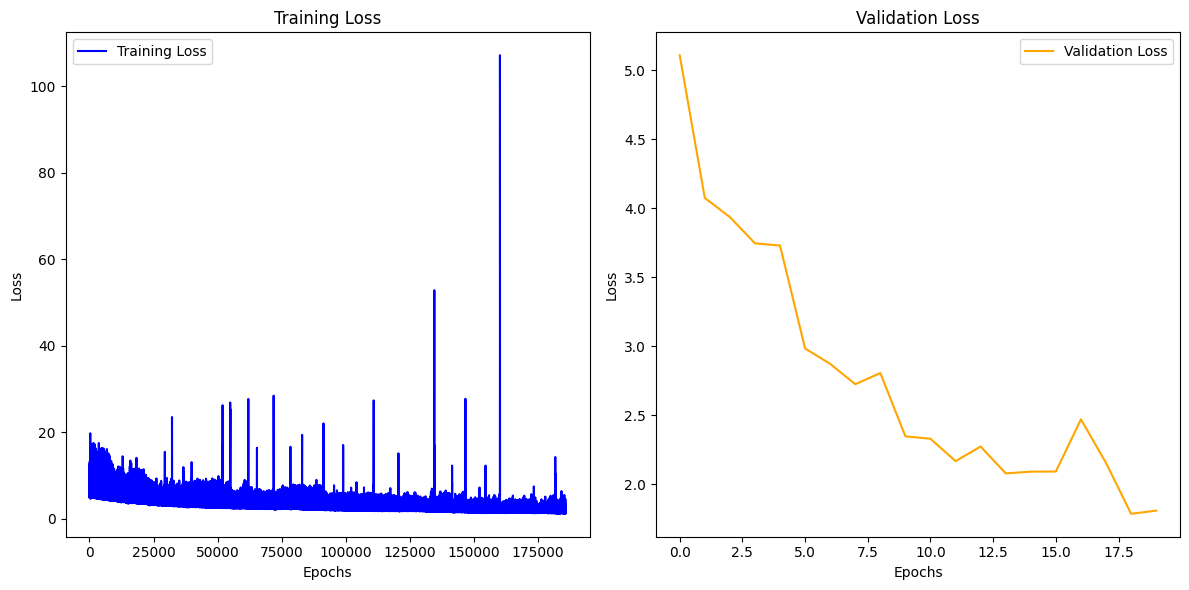

In [ ]:
# Convert loss_history to a list of NumPy arrays on CPU
train_loss_history_cpu = [loss.item() for loss in train_loss_history]
val_loss_history_cpu = [loss.item() for loss in val_loss_history]
train_loss_array = np.asarray(train_loss_history_cpu)
val_loss_array = np.asarray(val_loss_history_cpu)

# Create a new figure
plt.figure(figsize=(12, 6))

# Subfigure for training loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_array, label='Training Loss', color='blue')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Subfigure for validation loss
plt.subplot(1, 2, 2)
plt.plot(val_loss_array, label='Validation Loss', color='orange')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()  # Automatically adjusts spacing between subfigures
plt.show()

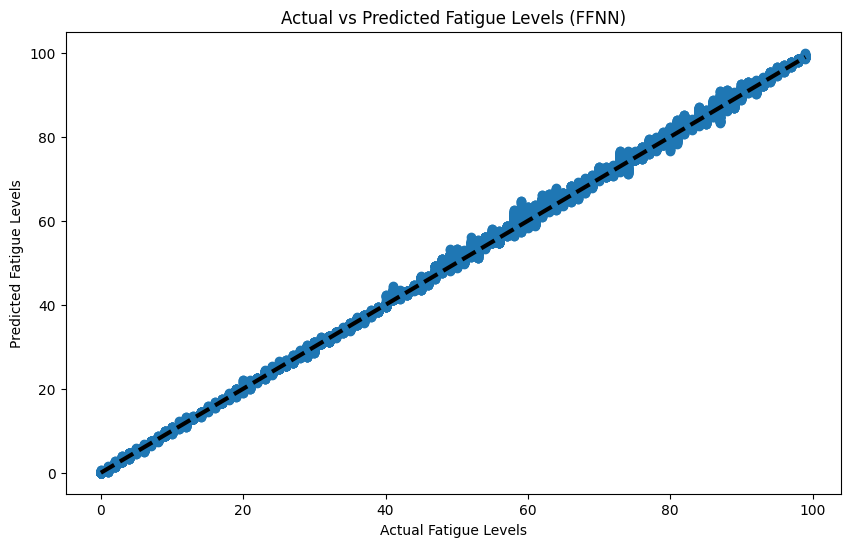

In [16]:
#@title Show linear correlation for normal training

plt.figure(figsize=(10, 6))
plt.scatter(y_test, outputs)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual Fatigue Levels')
plt.ylabel('Predicted Fatigue Levels')
plt.title('Actual vs Predicted Fatigue Levels (FFNN)')
plt.show()

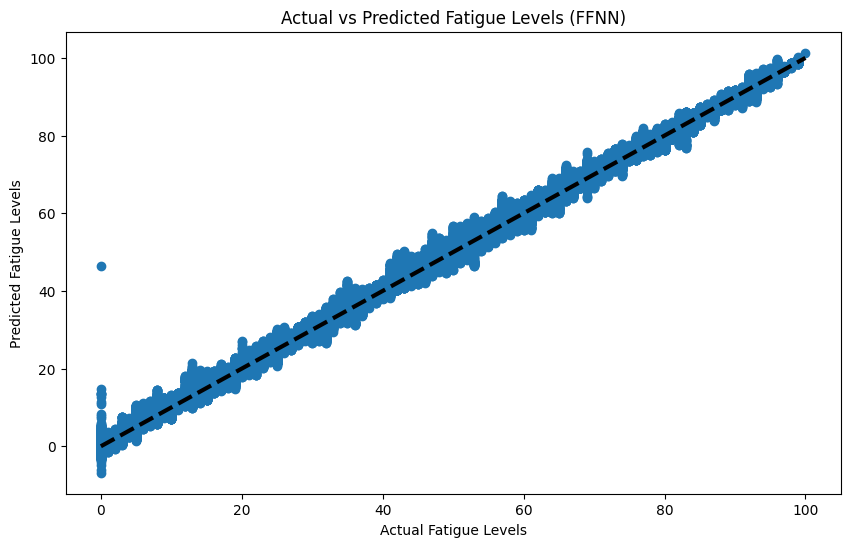

In [ ]:
#@title Show linear correlation for K-Fold Cross Validation

# Convert loss_history to a list of NumPy arrays on CPU
y_test_cpu = [y.item() for y in y_test]
outputs_cpu = [output.item() for output in test_outputs]
y_test_array = np.asarray(y_test_cpu)
outputs_array = np.asarray(outputs_cpu)

# Plotting predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_array, outputs_array)
plt.plot([y_test_array.min(), y_test_array.max()], [y_test_array.min(), y_test_array.max()], 'k--', lw=3)
plt.xlabel('Actual Fatigue Levels')
plt.ylabel('Predicted Fatigue Levels')
plt.title('Actual vs Predicted Fatigue Levels (FFNN)')
plt.show()


In [ ]:
# Save the trained model
joblib.dump(model, 'FFNN_model.pkl')

['FFNN_model.pkl']